# SCANIA Predictive Maintenance — Exploratory Data Analysis (EDA)

This notebook performs exploratory data analysis on the SCANIA Component X predictive maintenance dataset.

Data location:
- Azure Data Lake Storage Gen2 account: **scaniapdmstorage**
- Filesystem (container): **scania-dataset**
- Folders:
  - `train/`
  - `validation/`
  - `test/`

We will:
1. Connect to ADLS Gen2 from Azure ML compute.
2. Load the **training** CSVs:
   - `train_operational_readouts.csv`
   - `train_tte.csv`
   - `train_specifications.csv`
3. Inspect schema and basic statistics.
4. Explore the target variable (`in_study_repair`).
5. Analyze sequence lengths per vehicle (units, time_step).
6. Prepare ideas for feature engineering and modeling.

### Install dependencies

In [1]:
%pip install adlfs fsspec pandas matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 47.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2023.10.0
    Uninstalling fsspec-2023.10.0:
      Successfully uninstalled fsspec-2023.10.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9/9 [adlfs]32m8/9 [adlfs]p]
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
azureml-fsspec 1.3.1 requires fsspec<=2023.10.0,>=2021.6.1, but you have fsspec 2025.10.0 which is incompatible.

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: /anaconda/envs/azureml_py310_sdkv2/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### Imports & configuration

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

from adlfs import AzureBlobFileSystem

# ---------- CONFIGURATION ----------
ACCOUNT_NAME = "scaniapdmstorage"
FILE_SYSTEM = "scania-dataset"

# ⚠️ IMPORTANT:
# For now we use the storage account key directly for simplicity.
# DO NOT commit this key to GitHub. Consider moving it to an environment variable later.
ACCOUNT_KEY = "tMM0AEo95ysfrScREtwUNLpLj493AN1LfMlj4oIId+SruT7zsvNif48lHhY09ymSC8mXOW2o5FeI+AStLCeMiQ==" #"<PASTE-YOUR-STORAGE-ACCOUNT-KEY-HERE>"  # TODO: replace

# Paths inside the filesystem
TRAIN_OP_PATH = "scania-dataset/train/train_operational_readouts.csv"
TRAIN_TTE_PATH = "scania-dataset/train/train_tte.csv"
TRAIN_SPEC_PATH = "scania-dataset/train/train_specifications.csv"

# Create filesystem client
fs = AzureBlobFileSystem(
    account_name=ACCOUNT_NAME,
    account_key=ACCOUNT_KEY,
)

print("Connected to ADLS filesystem:", FILE_SYSTEM)

Connected to ADLS filesystem: scania-dataset


### Helper to read CSV from ADLS

In [4]:
def read_csv_from_adls(fs, path: str, **read_csv_kwargs) -> pd.DataFrame:
    """
    Read a CSV file from ADLS Gen2 into a pandas DataFrame.
    `path` is relative to the filesystem root, e.g. 'train/train_operational_readouts.csv'.
    """
    print(f"Loading: {path}")
    with fs.open(path, "rb") as f:
        df = pd.read_csv(f, **read_csv_kwargs)
    print(f"→ loaded shape: {df.shape}")
    return df

### Load the three training tables

In [7]:
df_oper = read_csv_from_adls(fs, TRAIN_OP_PATH)
df_tte = read_csv_from_adls(fs, TRAIN_TTE_PATH)
df_spec = read_csv_from_adls(fs, TRAIN_SPEC_PATH)

Loading: scania-dataset/train/train_operational_readouts.csv
→ loaded shape: (1122452, 107)
Loading: scania-dataset/train/train_tte.csv
→ loaded shape: (23550, 3)
Loading: scania-dataset/train/train_specifications.csv
→ loaded shape: (23550, 9)


### Quick schema inspection

In [8]:
print("Operational readouts columns:", len(df_oper.columns))
print(df_oper.columns[:20])  # show first 20 columns

print("\nTTE columns:", len(df_tte.columns))
print(df_tte.columns)

print("\nSpecifications columns:", len(df_spec.columns))
print(df_spec.columns)

Operational readouts columns: 107
Index(['vehicle_id', 'time_step', '171_0', '666_0', '427_0', '837_0', '167_0',
       '167_1', '167_2', '167_3', '167_4', '167_5', '167_6', '167_7', '167_8',
       '167_9', '309_0', '272_0', '272_1', '272_2'],
      dtype='object')

TTE columns: 3
Index(['vehicle_id', 'length_of_study_time_step', 'in_study_repair'], dtype='object')

Specifications columns: 9
Index(['vehicle_id', 'Spec_0', 'Spec_1', 'Spec_2', 'Spec_3', 'Spec_4',
       'Spec_5', 'Spec_6', 'Spec_7'],
      dtype='object')


In [9]:
# Peek at the head:
display(df_oper.head())
display(df_tte.head())
display(df_spec.head())

,vehicle_id,time_step,171_0,666_0,427_0,837_0,167_0,167_1,167_2,167_3,...,397_26,397_27,397_28,397_29,397_30,397_31,397_32,397_33,397_34,397_35
0,0,11.2,167985.0,10787.0,7413813.0,2296.0,4110.0,1296420.0,1628265.0,630345.0,...,95728.0,15609.0,1984.0,8.0,784.0,150228.0,261904.0,93172.0,17874.0,452.0
1,0,11.4,167985.0,10787.0,7413813.0,2296.0,4111.0,1302855.0,1628265.0,630345.0,...,95729.0,15610.0,1984.0,8.0,784.0,150228.0,261905.0,93172.0,17874.0,452.0
2,0,19.6,331635.0,14525.0,13683604.0,2600.0,NaN,NaN,NaN,NaN,...,142900.0,19263.0,2441.0,12.0,1420.0,204832.0,313485.0,106464.0,19306.0,452.0
3,0,20.2,354975.0,15015.0,14540449.0,2616.0,NaN,NaN,NaN,NaN,...,150565.0,19832.0,2522.0,12.0,1444.0,211688.0,318901.0,107745.0,19406.0,453.0
4,0,21.0,365550.0,15295.0,14966985.0,2720.0,NaN,NaN,NaN,NaN,...,155913.0,20573.0,2562.0,12.0,1445.0,213956.0,323997.0,109514.0,19535.0,454.0


,vehicle_id,length_of_study_time_step,in_study_repair
0,0,510.0,0
1,2,281.8,0
2,3,293.4,0
3,4,210.0,0
4,5,360.4,0


,vehicle_id,Spec_0,Spec_1,Spec_2,Spec_3,Spec_4,Spec_5,Spec_6,Spec_7
0,0,Cat0,Cat0,Cat0,Cat0,Cat0,Cat0,Cat0,Cat0
1,2,Cat0,Cat1,Cat1,Cat0,Cat0,Cat0,Cat0,Cat1
2,3,Cat0,Cat1,Cat1,Cat1,Cat0,Cat0,Cat0,Cat1
3,4,Cat0,Cat0,Cat2,Cat1,Cat0,Cat0,Cat0,Cat1
4,5,Cat0,Cat2,Cat2,Cat0,Cat0,Cat0,Cat0,Cat1


### Basic info & missing values

In [10]:
print("=== Operational readouts info ===")
df_oper.info()

print("\n=== TTE info ===")
df_tte.info()

print("\n=== Specifications info ===")
df_spec.info()

# Basic missing value check:
print("Missing values (operational):")
display(df_oper.isna().mean().sort_values(ascending=False).head(20))

print("\nMissing values (tte):")
display(df_tte.isna().mean().sort_values(ascending=False))

print("\nMissing values (specifications):")
display(df_spec.isna().mean().sort_values(ascending=False))

=== Operational readouts info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1122452 entries, 0 to 1122451
Columns: 107 entries, vehicle_id to 397_35
dtypes: float64(106), int64(1)
memory usage: 916.3 MB

=== TTE info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23550 entries, 0 to 23549
Data columns (total 3 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   vehicle_id                 23550 non-null  int64  
 1   length_of_study_time_step  23550 non-null  float64
 2   in_study_repair            23550 non-null  int64  
dtypes: float64(1), int64(2)
memory usage: 552.1 KB

=== Specifications info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23550 entries, 0 to 23549
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   vehicle_id  23550 non-null  int64 
 1   Spec_0      23550 non-null  object
 2   Spec_1      23550 non-null  o

291_6     0.008578
291_2     0.008578
291_0     0.008578
291_10    0.008578
291_9     0.008578
291_8     0.008578
291_7     0.008578
291_1     0.008578
291_5     0.008578
291_4     0.008578
291_3     0.008578
459_7     0.007442
459_6     0.007442
459_5     0.007442
459_2     0.007442
459_10    0.007442
459_4     0.007442
459_3     0.007442
459_1     0.007442
459_0     0.007442
dtype: float64


Missing values (tte):


vehicle_id                   0.0
length_of_study_time_step    0.0
in_study_repair              0.0
dtype: float64


Missing values (specifications):


vehicle_id    0.0
Spec_0        0.0
Spec_1        0.0
Spec_2        0.0
Spec_3        0.0
Spec_4        0.0
Spec_5        0.0
Spec_6        0.0
Spec_7        0.0
dtype: float64

### Target variable exploration (in_study_repair)

Target value counts:
0    21278
1     2272
Name: in_study_repair, dtype: int64

Target value proportions:
0    0.903524
1    0.096476
Name: in_study_repair, dtype: float64


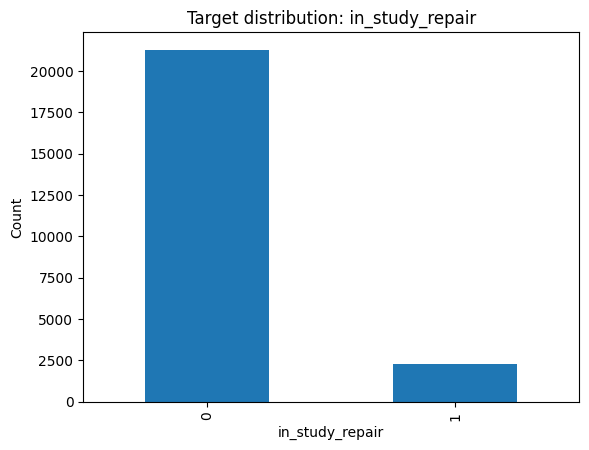

In [11]:
TARGET_COL = "in_study_repair"

if TARGET_COL in df_tte.columns:
    print("Target value counts:")
    print(df_tte[TARGET_COL].value_counts(dropna=False))

    print("\nTarget value proportions:")
    print(df_tte[TARGET_COL].value_counts(normalize=True, dropna=False))

    # Simple bar plot
    df_tte[TARGET_COL].value_counts().plot(kind="bar")
    plt.title("Target distribution: in_study_repair")
    plt.xlabel("in_study_repair")
    plt.ylabel("Count")
    plt.show()
else:
    print(f"Column '{TARGET_COL}' not found in df_tte. Available columns:")
    print(df_tte.columns)

### Units and time_step structure
We want to understand the sequence length per vehicle (unit) in the operational data.

Columns in operational data: Index(['vehicle_id', 'time_step', '171_0', '666_0', '427_0', '837_0', '167_0',
       '167_1', '167_2', '167_3'],
      dtype='object')
Number of unique units in operational data: 23550

Sequence length summary (rows per unit):
count    23550.000000
mean        47.662505
std         27.406028
min          5.000000
25%         28.000000
50%         43.000000
75%         64.000000
max        303.000000
Name: time_step, dtype: float64


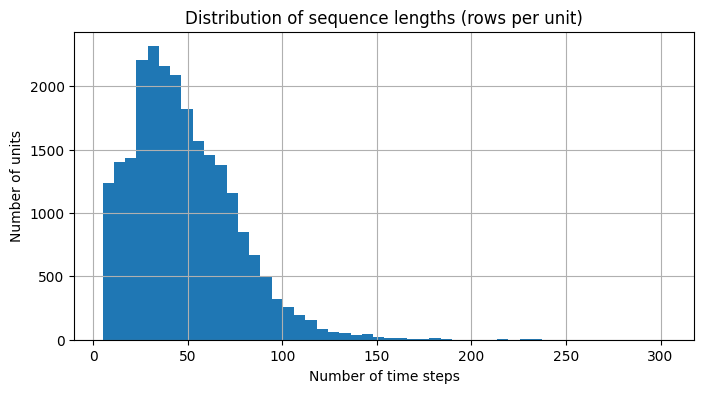

In [13]:
UNIT_COL = "vehicle_id"         # or 'vehicle_id' / 'unit_id' depending on dataset
TIME_COL = "time_step"    # time index within vehicle

print("Columns in operational data:", df_oper.columns[:10])

# Sanity check
if UNIT_COL not in df_oper.columns or TIME_COL not in df_oper.columns:
    raise ValueError(f"Expected columns '{UNIT_COL}' and '{TIME_COL}' not found in df_oper.")

# Number of unique units
n_units = df_oper[UNIT_COL].nunique()
print(f"Number of unique units in operational data: {n_units}")

# Sequence length (number of rows) per unit
seq_lengths = df_oper.groupby(UNIT_COL)[TIME_COL].count()

print("\nSequence length summary (rows per unit):")
print(seq_lengths.describe())

# Plot distribution of sequence lengths
plt.figure(figsize=(8, 4))
seq_lengths.hist(bins=50)
plt.title("Distribution of sequence lengths (rows per unit)")
plt.xlabel("Number of time steps")
plt.ylabel("Number of units")
plt.show()

### Time_step range per unit
Check if time_step is contiguous and how it varies:

In [14]:
agg_time = df_oper.groupby(UNIT_COL)[TIME_COL].agg(["min", "max", "nunique"])
agg_time["range"] = agg_time["max"] - agg_time["min"] + 1

print("First 10 units' time_step ranges:")
display(agg_time.head(10))

print("\nSummary of time_step range per unit:")
display(agg_time["range"].describe())

First 10 units' time_step ranges:


,min,max,nunique,range
vehicle_id,,,,
0,11.2,507.4,172,497.2
2,1.4,281.0,33,280.6
3,0.2,291.2,71,292.0
4,3.8,203.0,17,200.2
5,0.0,357.6,44,358.6
8,1.8,277.6,23,276.8
13,2.2,149.4,26,148.2
14,1.4,432.8,42,432.4
15,4.2,286.8,56,283.6



Summary of time_step range per unit:


count    23550.000000
mean       228.210692
std         89.700115
min         12.200000
25%        151.200000
50%        209.400000
75%        297.950000
max        505.200000
Name: range, dtype: float64

### Merge TTE with operational data
We’ll create a combined table to see target labels next to sequences.

In [16]:
# Check common keys
print("Common columns between operational and TTE:", set(df_oper.columns) & set(df_tte.columns))

# Join on UNIT: 'vehicle_id'
merge_keys = [UNIT_COL]

if not all(col in df_tte.columns for col in merge_keys):
    print("TTE does not have expected merge keys. Available columns:")
    print(df_tte.columns)
else:
    df_merged = pd.merge(
        df_oper,
        df_tte,
        on=merge_keys,
        how="left",
        suffixes=("", "_tte"),
    )

    print("Merged shape (operational + TTE):", df_merged.shape)
    display(df_merged.head())

Common columns between operational and TTE: {'vehicle_id'}
Merged shape (operational + TTE): (1122452, 109)


,vehicle_id,time_step,171_0,666_0,427_0,837_0,167_0,167_1,167_2,167_3,...,397_28,397_29,397_30,397_31,397_32,397_33,397_34,397_35,length_of_study_time_step,in_study_repair
0,0,11.2,167985.0,10787.0,7413813.0,2296.0,4110.0,1296420.0,1628265.0,630345.0,...,1984.0,8.0,784.0,150228.0,261904.0,93172.0,17874.0,452.0,510.0,0
1,0,11.4,167985.0,10787.0,7413813.0,2296.0,4111.0,1302855.0,1628265.0,630345.0,...,1984.0,8.0,784.0,150228.0,261905.0,93172.0,17874.0,452.0,510.0,0
2,0,19.6,331635.0,14525.0,13683604.0,2600.0,NaN,NaN,NaN,NaN,...,2441.0,12.0,1420.0,204832.0,313485.0,106464.0,19306.0,452.0,510.0,0
3,0,20.2,354975.0,15015.0,14540449.0,2616.0,NaN,NaN,NaN,NaN,...,2522.0,12.0,1444.0,211688.0,318901.0,107745.0,19406.0,453.0,510.0,0
4,0,21.0,365550.0,15295.0,14966985.0,2720.0,NaN,NaN,NaN,NaN,...,2562.0,12.0,1445.0,213956.0,323997.0,109514.0,19535.0,454.0,510.0,0


### Join specifications
Specifications are static per unit; we can merge them into the merged table:

In [17]:
if UNIT_COL not in df_spec.columns:
    print("UNIT_COL not found in specifications; columns are:")
    print(df_spec.columns)
else:
    df_full = pd.merge(
        df_merged,
        df_spec,
        on=UNIT_COL,
        how="left",
        suffixes=("", "_spec"),
    )

    print("Full merged shape (operational + TTE + specs):", df_full.shape)
    display(df_full.head())

Full merged shape (operational + TTE + specs): (1122452, 117)


,vehicle_id,time_step,171_0,666_0,427_0,837_0,167_0,167_1,167_2,167_3,...,length_of_study_time_step,in_study_repair,Spec_0,Spec_1,Spec_2,Spec_3,Spec_4,Spec_5,Spec_6,Spec_7
0,0,11.2,167985.0,10787.0,7413813.0,2296.0,4110.0,1296420.0,1628265.0,630345.0,...,510.0,0,Cat0,Cat0,Cat0,Cat0,Cat0,Cat0,Cat0,Cat0
1,0,11.4,167985.0,10787.0,7413813.0,2296.0,4111.0,1302855.0,1628265.0,630345.0,...,510.0,0,Cat0,Cat0,Cat0,Cat0,Cat0,Cat0,Cat0,Cat0
2,0,19.6,331635.0,14525.0,13683604.0,2600.0,NaN,NaN,NaN,NaN,...,510.0,0,Cat0,Cat0,Cat0,Cat0,Cat0,Cat0,Cat0,Cat0
3,0,20.2,354975.0,15015.0,14540449.0,2616.0,NaN,NaN,NaN,NaN,...,510.0,0,Cat0,Cat0,Cat0,Cat0,Cat0,Cat0,Cat0,Cat0
4,0,21.0,365550.0,15295.0,14966985.0,2720.0,NaN,NaN,NaN,NaN,...,510.0,0,Cat0,Cat0,Cat0,Cat0,Cat0,Cat0,Cat0,Cat0


### Example feature exploration
Pick a numerical feature to inspect (you may need to adjust the column name to a real one like "167_bin_0" or similar):

Example feature: 666_0


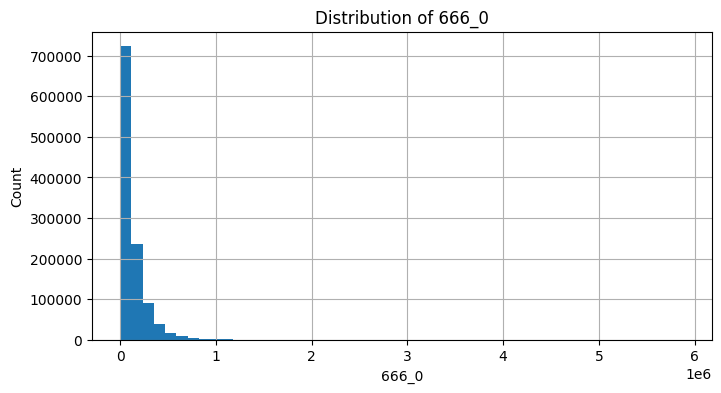

In [18]:
# Replace with a real sensor/feature column from df_oper
example_feature = df_oper.columns[3]  # just as a starting point
print("Example feature:", example_feature)

plt.figure(figsize=(8, 4))
df_oper[example_feature].hist(bins=50)
plt.title(f"Distribution of {example_feature}")
plt.xlabel(example_feature)
plt.ylabel("Count")
plt.show()

### Save some summaries for later

This makes it easy to reference in documentation.

In [ ]:
# Save basic stats to CSV (local to the compute)
desc_oper = df_oper.describe().T
desc_tte = df_tte.describe().T
desc_spec = df_spec.describe().T

desc_oper.to_csv("eda_operational_describe.csv")
desc_tte.to_csv("eda_tte_describe.csv")
desc_spec.to_csv("eda_spec_describe.csv")

print("Saved basic describe() statistics to local CSV files in the notebook environment.")